# DataJoint usage example
- Examples fetching data from the DataJoint database.

In [1]:
import numpy as np
import pandas as pd

import datajoint as dj

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

# from scipy.stats import pearsonr, percentileofscore

from lib.utils import *
from lib.datajoint import *
from lib.calcium import *
from lib.plot import *

%matplotlib inline

## Connect to DataJoint database
- You need to be registered to access the database. Please register [here](https://forms.gle/6SeDGRT8zoLqpbfU9).
- For more information, refer to [README](https://github.com/seung-lab/MicronsBinder/blob/master/notebooks/multiscale/function/README.md) in the repository.
#### Currently, it is temporarily available without registration for the review process. Try running below cell.

In [2]:
# dj.config["database.host"] = "datajoint.ninai.org"
dj.config.load("dj_conf.json")
dj.conn()

pinky = dj.create_virtual_module("seung_pinky", "seung_pinky")

Connecting seung_guest@datajoint.ninai.org:3306


## All pyramidal cells (PyCs)

In [3]:
pyc_list = pinky.Neuron().fetch("segment_id")
n_pyc = pyc_list.shape[0]

## PyCs with functional data

In [4]:
pyc_func_list = pinky.EASETuning().fetch("segment_id")
n_func = pyc_func_list.shape[0]

osi_p = pinky.EASETuning().fetch("osi_p")
dsi_p = pinky.EASETuning().fetch("dsi_p")

tune_idx = osi_p<0.01

## Spatial organization of in-connection density

In [5]:
pyc_soma_loc = np.zeros((n_pyc, 3))
for i in range(n_pyc):
    
    seg_id = pyc_list[i]
    pyc_soma_loc[i,:] = get_soma_loc(pinky, seg_id) # In um

In [7]:
inconn_density = np.zeros((n_pyc,))
for i in range(n_pyc):
    
    seg_id = pyc_list[i]
    inconn_density[i] = get_density(pinky, seg_id, "inconn_dens")

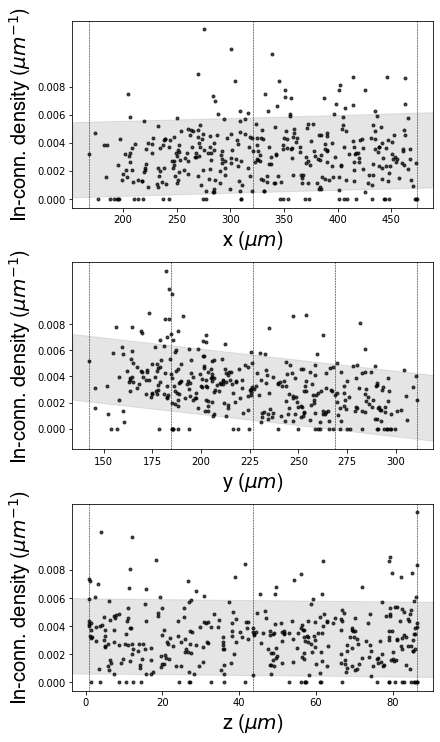

In [12]:
xloc = pyc_soma_loc[:,0]
yloc = pyc_soma_loc[:,1]
zloc = pyc_soma_loc[:,2]

fig = plt.figure(figsize=(6,10), constrained_layout=True)
gs = fig.add_gridspec(3,1)

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[2,0])
plot_spatial_ax(ax1, xloc, inconn_density, nbins=3, xlab="x ($\mu m$)")
plot_spatial_ax(ax2, yloc, inconn_density, nbins=5, xlab="y ($\mu m$)")
plot_spatial_ax(ax3, zloc, inconn_density, nbins=3, xlab="z ($\mu m$)")

## Visualize visual response

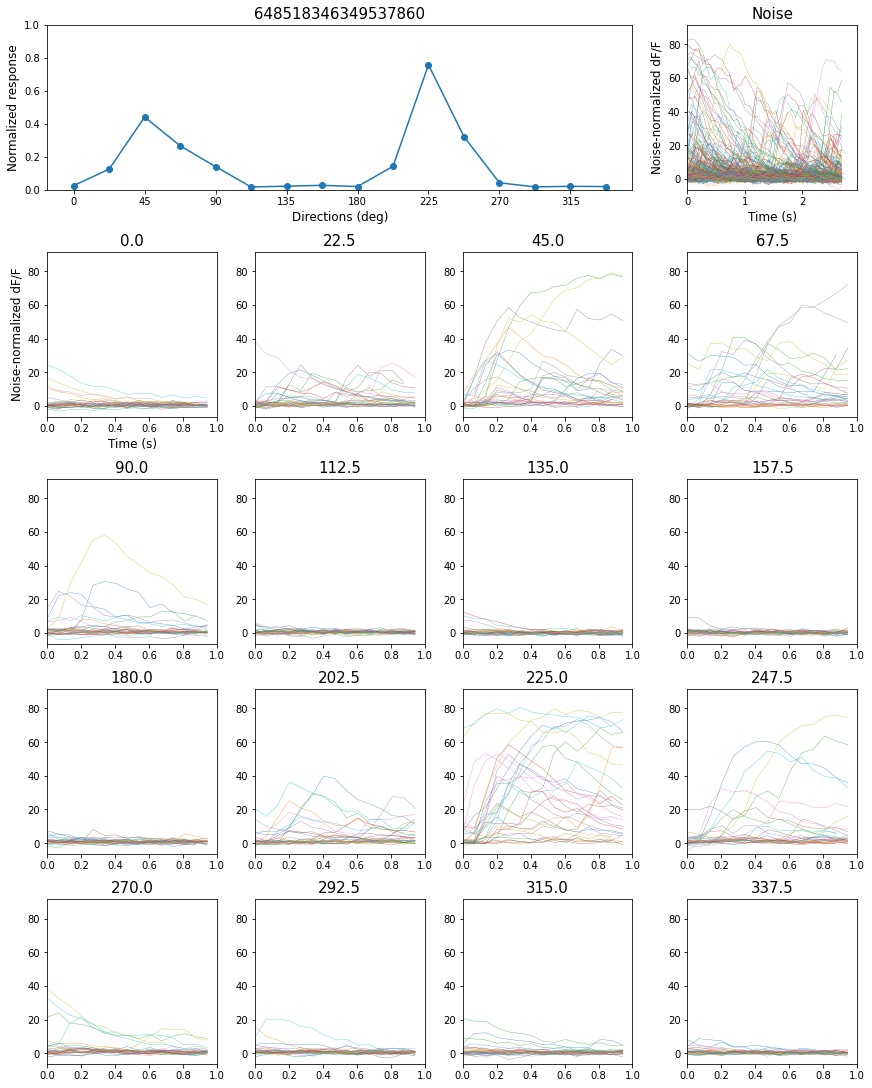

In [4]:
fig = plt.figure(figsize=(12,15), constrained_layout=True)
gs = fig.add_gridspec(5,4)

seg_id = 648518346349537860

scan_id = get_scan(pinky, seg_id)
trace = get_trace(pinky, seg_id, scan_id, "trace_raw")
tune_curve = get_tuning(pinky, seg_id, scan_id)
stimlab = get_stim_label(pinky, scan_id)
ylim = [0, trace.max()*1.1]

# Plot tuning curve
f_ax1 = fig.add_subplot(gs[0,0:3])
f_ax1.set_title(seg_id, fontsize=15)
plot_tuning_curve(tune_curve, f_ax1)

# Plot responses to noise stimulus
f_ax2 = fig.add_subplot(gs[0,3])
f_ax2.set_title("Noise", fontsize=15)
plot_trial(trace, stimlab, np.nan, f_ax2)
f_ax2.set_xlabel("Time (s)", fontsize=12)
f_ax2.set_ylabel("Noise-normalized dF/F", fontsize=12)

# Plot responses to each directional stimulus
for d in range(16):
    ii = d//4
    jj = np.remainder(d,4)

    f_axd = fig.add_subplot(gs[ii+1, jj])
    f_axd.set_title("{}".format(22.5*d), fontsize=15)
    plot_trial(trace, stimlab, 22.5*d, f_axd, [0,1])
    if d==0:
        f_axd.set_xlabel("Time (s)", fontsize=12)
        f_axd.set_ylabel("Noise-normalized dF/F", fontsize=12)

plt.show()

## Intermittency is correlated with in-connection density

In [19]:
inconn_density = np.zeros((n_func,))
total_insyn_density = np.zeros((n_func,))
for i in range(n_func):
    
    seg_id = pyc_func_list[i]
    inconn_density[i] = get_density(pinky, seg_id, "inconn_dens")
    total_insyn_density[i] = get_density(pinky, seg_id, "total_insyn_dens")

In [14]:
intermittency = np.zeros(n_func)
for i in range(n_func):
    
    seg_id = pyc_func_list[i]
    scan_id = get_scan(pinky, seg_id)

    trace = get_trace(pinky, seg_id, scan_id, "trace_raw")
    spike = get_trace(pinky, seg_id, scan_id, "spike")
    stimlab = get_stim_label(pinky, scan_id)
    
    response_array = get_peakamp_tdarray(trace, stimlab)
    tune = tuning_curve(response_array)
    dir_pref = np.argmax(tune)
    dir_opp = np.remainder(dir_pref+8, 16)
    
    if dsi_p[pyc_func_list==seg_id]<0.01:
        pref_idx = [dir_pref]
    else:
        pref_idx = [dir_pref, dir_opp]
        
    intermittency[i] = compute_intermittency(spike, stimlab, pref_idx, thr=3)

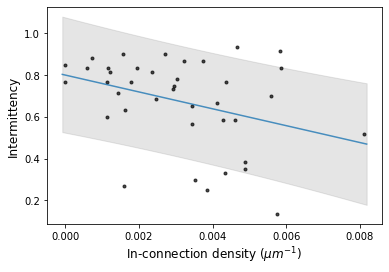

r = -0.3526467029064188, p = 0.027672033952303273


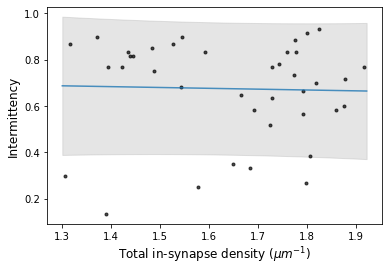

r = -0.030240020253543172, p = 0.8549971406210989


In [20]:
plot_linear_fit(inconn_density[tune_idx], intermittency[tune_idx],
         xlab="In-connection density ($\mu m^{-1}$)",
         ylab="Intermittency")

plot_linear_fit(total_insyn_density[tune_idx], intermittency[tune_idx],
         xlab="Total in-synapse density ($\mu m^{-1}$)",
         ylab="Intermittency")